# **Rossman Store Sales Forecasting**

### **Introduction**

> A project that aims to build a predictive analytics dashboard that will help the Rossman stores forecast their future sales.I will work with historical transaction data, apply machine learning models to predict upcoming trends, and present insights with an interactive Power BI dashboard.

### **Business Understanding**

>  **Business Goal:** Develop an accurate sales forecasting model to:
> - Optimize inventory levels
> - Improve resource allocation
> - Support strategic decision-making
> - Reduce stockouts and overstock situations

> **Success Criteria:** Minimize forecasting errors (MAE, RMSE, MAPE)

### **Data Understanding**

In [1]:
# Install prophet
#!pip install prophet

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Statistical models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# Prophet
from prophet import Prophet


In [3]:
# Load the datasets
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')
store_df = pd.read_csv('Data/store.csv')

# Display the shape of the datasets
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("Store dataset shape:", store_df.shape)

<ipython-input-3-93b0369b7da4>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('Data/train.csv')


Train dataset shape: (1017209, 9)
Test dataset shape: (41088, 8)
Store dataset shape: (1115, 10)


In [4]:
# Display first 5 rows of the training dataset
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
# Display first 5 rows of the test dataset
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
# Display first 5 rows of the store dataset
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
# train data information and statistics
print(train_df.info())
display(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
#test data information and statistics
print(test_df.info())
display(test_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB
None


,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [9]:
# store data information and statistics
print(store_df.info())
display(store_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [10]:
#Check for missing values in the datasets
# Train data
print(train_df.isnull().sum())
#Test data
print(test_df.isnull().sum())
#store data
print(store_df.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [11]:
# Check for duplicates in the datasets
print("Train duplicates:", train_df.duplicated().sum())
print("Test duplicates:", test_df.duplicated().sum()) 
print("Store duplicates:", store_df.duplicated().sum())

Train duplicates: 0
Test duplicates: 0
Store duplicates: 0


### **Data Preperation**

In [12]:
# Merge train data with store information
if 'Store' in train_df.columns and 'Store' in store_df.columns:
    train_full = train_df.merge(store_df, on='Store', how='left')
    test_full = test_df.merge(store_df, on='Store', how='left')

# Display the shape of the merged datasets
print("Merged train dataset shape:", train_full.shape)
print("Merged test dataset shape:", test_full.shape)

Merged train dataset shape: (1017209, 18)
Merged test dataset shape: (41088, 17)


In [13]:
# convert date column to datetime
date_columns = [col for col in train_full.columns if 'date' in col.lower()]
date_col = date_columns[0]
train_full[date_col] = pd.to_datetime(train_full[date_col])
test_full[date_col] = pd.to_datetime(test_full[date_col])

# Sort by date
train_full = train_full.sort_values(date_col).reset_index(drop=True)
test_full = test_full.sort_values(date_col).reset_index(drop=True)

In [14]:
# Display sales statistics
sales_col = 'Sales'
print(train_full[sales_col].describe())

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64


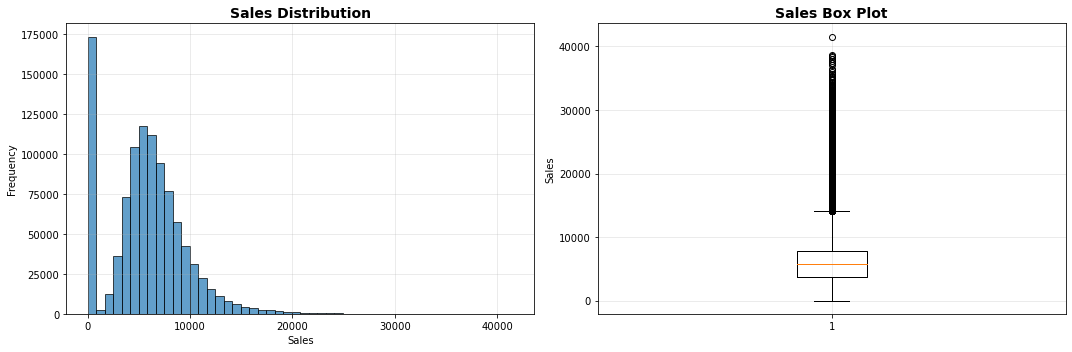


Sales range: 0.00 to 41551.00
Mean sales: 5773.82
Median sales: 5744.00


In [15]:
#EDA visualizations
# Sales distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Histogram
axes[0].hist(train_full[sales_col], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Sales Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(train_full[sales_col].dropna())
axes[1].set_title('Sales Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sales')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSales range: {train_full[sales_col].min():.2f} to {train_full[sales_col].max():.2f}")
print(f"Mean sales: {train_full[sales_col].mean():.2f}")
print(f"Median sales: {train_full[sales_col].median():.2f}")

In [16]:
# Aggregate daily sales for time series analysis
daily_sales = train_full.groupby(date_col)[sales_col].sum().reset_index()
daily_sales.columns = ['Date', 'Sales']
daily_sales = daily_sales.sort_values('Date').reset_index(drop=True)

print(f"Daily aggregated sales shape: {daily_sales.shape}")
print(f"Date range: {daily_sales['Date'].min()} to {daily_sales['Date'].max()}")

Daily aggregated sales shape: (942, 2)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00


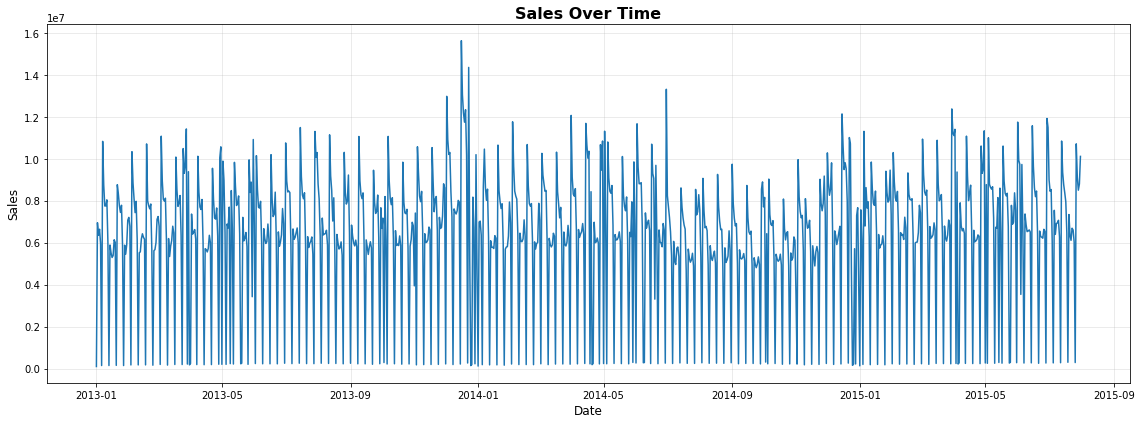

In [17]:
# Time series plot using pandas
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(daily_sales['Date'].values, daily_sales['Sales'].values, linewidth=1.5)
ax.set_title('Sales Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sales', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

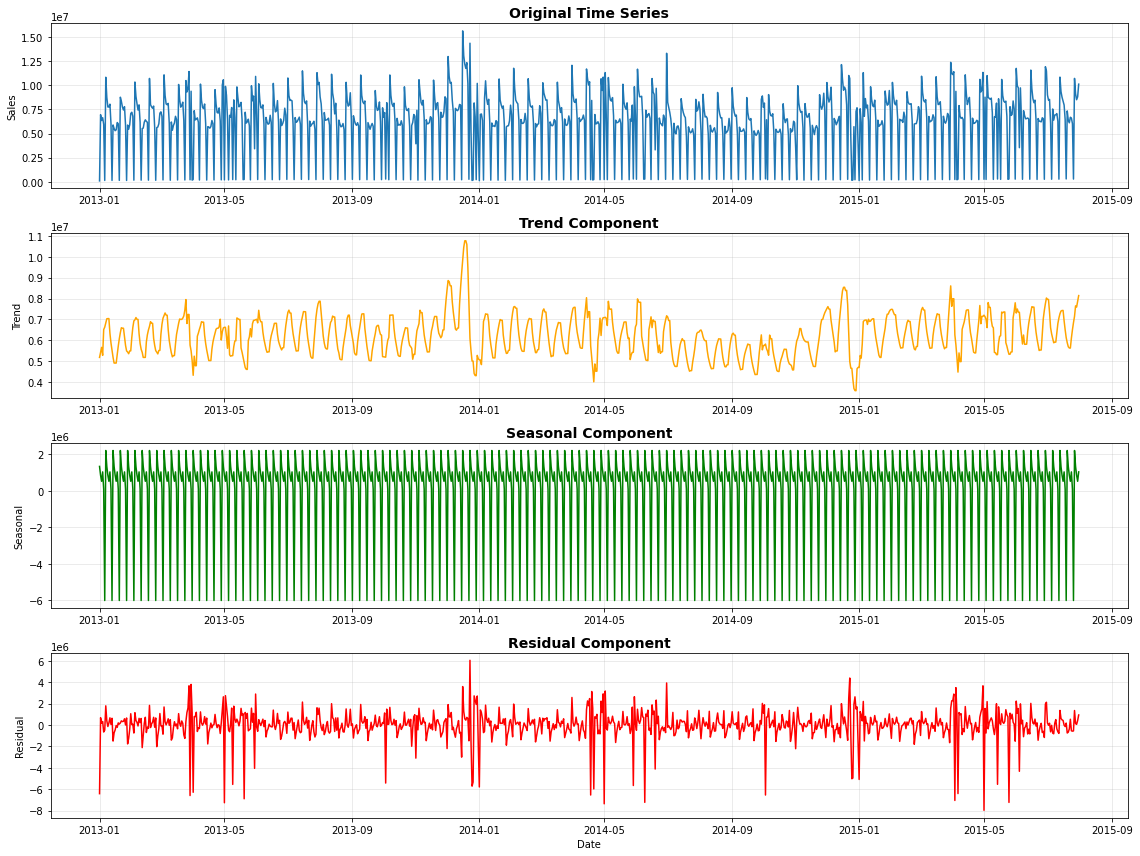

In [ ]:
#Time series decomposition
# Setting date as index for decomposition
daily_sales_indexed = daily_sales.set_index('Date')

# Performing seasonal decomposition (using additive model)
# Period = 7 for weekly seasonality, adjust if needed
try:
    decomposition = seasonal_decompose(daily_sales_indexed['Sales'], 
                                       model='additive', 
                                       period=7,
                                       extrapolate_trend='freq')
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    # Original
    axes[0].plot(decomposition.observed, linewidth=1.5)
    axes[0].set_title('Original Time Series', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Sales')
    axes[0].grid(True, alpha=0.3)
    
    # Trend
    axes[1].plot(decomposition.trend, linewidth=1.5, color='orange')
    axes[1].set_title('Trend Component', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Trend')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal
    axes[2].plot(decomposition.seasonal, linewidth=1.5, color='green')
    axes[2].set_title('Seasonal Component', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Seasonal')
    axes[2].grid(True, alpha=0.3)
    
    # Residual
    axes[3].plot(decomposition.resid, linewidth=1.5, color='red')
    axes[3].set_title('Residual Component', fontsize=14, fontweight='bold')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Decomposition failed: {e}")
    print("This may be due to insufficient data points or irregular frequency.")

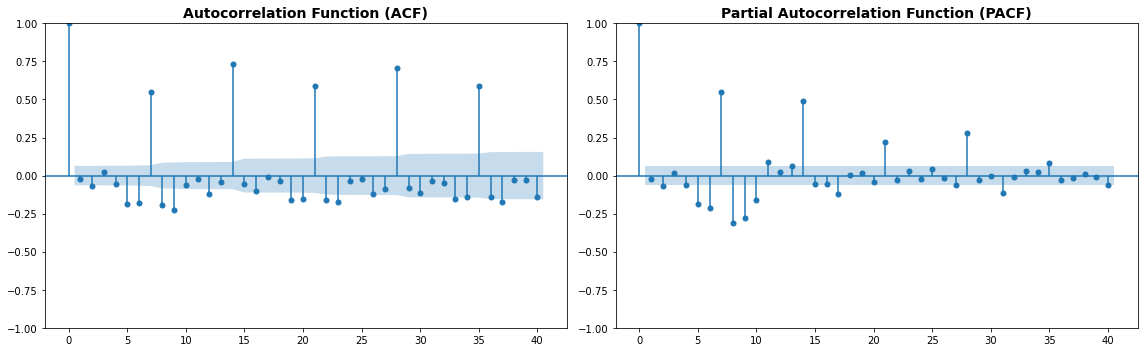

In [19]:
# ACF and PACF plots for understanding autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(daily_sales['Sales'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')

plot_pacf(daily_sales['Sales'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

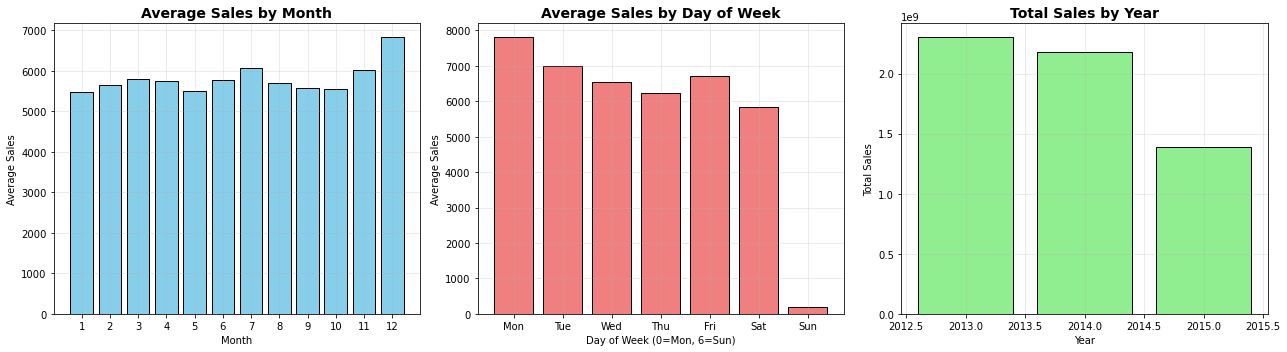

In [20]:
# convert the date column to datetime format
train_full[date_col] = pd.to_datetime(train_full[date_col])

# create the datetime features
train_full['Year'] = train_full[date_col].dt.year
train_full['Month'] = train_full[date_col].dt.month
train_full['DayOfWeek'] = train_full[date_col].dt.dayofweek

# Monthly and yearly patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sales by month
monthly_sales = train_full.groupby('Month')[sales_col].mean()
axes[0].bar(monthly_sales.index, monthly_sales.values, color='skyblue', edgecolor='black')
axes[0].set_title('Average Sales by Month', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Sales')
axes[0].set_xticks(range(1, 13))
axes[0].grid(True, alpha=0.3)

# Sales by day of week
dow_sales = train_full.groupby('DayOfWeek')[sales_col].mean()
axes[1].bar(dow_sales.index, dow_sales.values, color='lightcoral', edgecolor='black')
axes[1].set_title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week (0=Mon, 6=Sun)')
axes[1].set_ylabel('Average Sales')
axes[1].set_xticks(range(0, 7))
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1].grid(True, alpha=0.3)

# Sales by year
yearly_sales = train_full.groupby('Year')[sales_col].sum()
axes[2].bar(yearly_sales.index, yearly_sales.values, color='lightgreen', edgecolor='black')
axes[2].set_title('Total Sales by Year', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Total Sales')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
#Feature engineering
#Creating features to help the model capture temporal patterns and trends
def create_time_features(df, date_col):
    """
    Create datetime-based features from date column
    """
    df = df.copy()
    
    # Convert date column to datetime first
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Basic datetime features
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month
    df['Day'] = df[date_col].dt.day
    df['DayOfWeek'] = df[date_col].dt.dayofweek
    df['DayOfYear'] = df[date_col].dt.dayofyear
    df['WeekOfYear'] = df[date_col].dt.isocalendar().week
    df['Quarter'] = df[date_col].dt.quarter
    
    # Weekend indicator
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
    
    # Month start/end indicators
    df['IsMonthStart'] = df[date_col].dt.is_month_start.astype(int)
    df['IsMonthEnd'] = df[date_col].dt.is_month_end.astype(int)
    
    # Cyclical encoding for month and day of week
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    
    return df

# Apply feature engineering
train_full = create_time_features(train_full, date_col)
test_full = create_time_features(test_full, date_col)

print(f"Train set shape: {train_full.shape}")
print(f"Test set shape: {test_full.shape}")

Train set shape: (1017209, 31)
Test set shape: (41088, 30)


In [22]:
def create_lag_features(df, target_col, date_col, lags=[1, 7, 14, 30]):
    """
    Create lag features for time series prediction
    """
    df = df.copy()
    df = df.sort_values(date_col).reset_index(drop=True)
    
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    return df

def create_rolling_features(df, target_col, date_col, windows=[7, 14, 30]):
    """
    Create rolling statistics features
    """
    df = df.copy()
    df = df.sort_values(date_col).reset_index(drop=True)
    
    for window in windows:
        # Rolling mean
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        # Rolling std
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
        # Rolling min
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window).min()
        # Rolling max
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window).max()
    
    return df

# Create lag and rolling features
train_full = create_lag_features(train_full, sales_col, date_col, lags=[1, 7, 14, 30])
train_full = create_rolling_features(train_full, sales_col, date_col, windows=[7, 14, 30])

print(f"New shape: {train_full.shape}")

New shape: (1017209, 47)


In [23]:
# Monthly averages
train_full['Monthly_Avg'] = train_full.groupby(['Year', 'Month'])[sales_col].transform('mean')

# Seasonal indicators
# Winter: Dec, Jan, Feb (12, 1, 2)
# Spring: Mar, Apr, May (3, 4, 5)
# Summer: Jun, Jul, Aug (6, 7, 8)
# Fall: Sep, Oct, Nov (9, 10, 11)
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

train_full['Season'] = train_full['Month'].apply(get_season)
test_full['Season'] = test_full['Month'].apply(get_season)

# Holiday spike indicators (example: end of year, mid-year)
train_full['EndOfYear'] = ((train_full['Month'] == 12) & (train_full['Day'] > 20)).astype(int)
test_full['EndOfYear'] = ((test_full['Month'] == 12) & (test_full['Day'] > 20)).astype(int)

print("Monthly averages and seasonal indicators created!")
print(f"Final training shape: {train_full.shape}")

Monthly averages and seasonal indicators created!
Final training shape: (1017209, 50)



Top 15 Features Correlated with Sales:
Sales                    1.000000
Customers                0.894711
Sales_rolling_mean_7     0.785505
Sales_rolling_mean_14    0.766914
Sales_rolling_mean_30    0.750544
Sales_rolling_max_7      0.694869
Sales_rolling_min_7      0.691580
Open                     0.678472
Sales_rolling_min_14     0.658267
Sales_rolling_max_14     0.634968
Sales_rolling_min_30     0.614242
Sales_rolling_max_30     0.566546
Sales_lag_1              0.562612
Sales_lag_7              0.560635
Sales_lag_14             0.553868
Name: Sales, dtype: float64


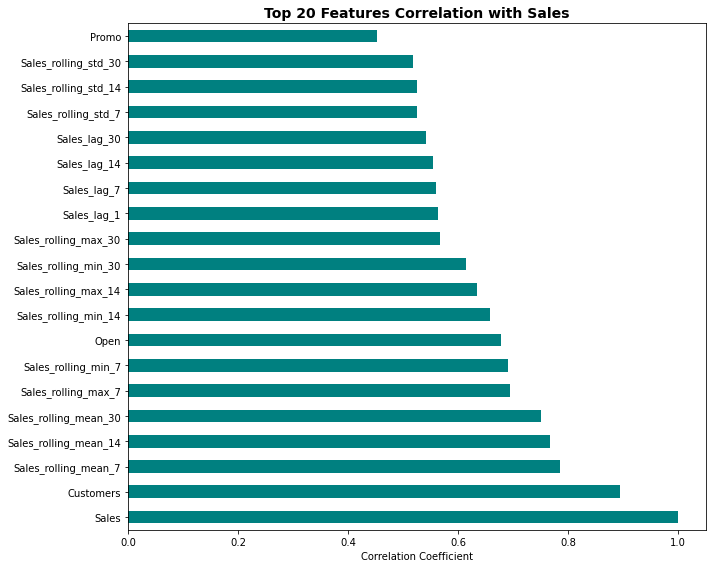

In [24]:
# Display feature correlations with target
# Select numerical features
numeric_cols = train_full.select_dtypes(include=[np.number]).columns.tolist()
if sales_col in numeric_cols:
    correlations = train_full[numeric_cols].corr()[sales_col].sort_values(ascending=False)
    
    print("\nTop 15 Features Correlated with Sales:")
    print(correlations.head(15))
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    correlations.head(20).plot(kind='barh', ax=ax, color='teal')
    ax.set_title('Top 20 Features Correlation with Sales', fontsize=14, fontweight='bold')
    ax.set_xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()

In [25]:
#Data preprocessing before modeling
#Remove rows with NaN values created by lag/rolling features
print(f"Original training size: {len(train_full)}")
train_clean = train_full.dropna().reset_index(drop=True)
print(f"Cleaned training size: {len(train_clean)}")
print(f"Rows removed: {len(train_full) - len(train_clean)}")

Original training size: 1017209
Cleaned training size: 324301
Rows removed: 692908


In [26]:
# Define feature columns for the ML models
# Exclude target, date, and identifier columns
exclude_cols = [sales_col, date_col, 'Store'] if 'Store' in train_clean.columns else [sales_col, date_col]
feature_cols = [col for col in train_clean.select_dtypes(include=[np.number]).columns 
                if col not in exclude_cols]

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]}...")  # Show first 10


Number of features: 43
Features: ['DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek']...


In [27]:
# Prepare data for modeling
X = train_clean[feature_cols]
y = train_clean[sales_col]

# Split into train and validation sets (80/20 split, maintaining temporal order)
split_idx = int(len(X) * 0.8)
X_train = X.iloc[:split_idx]
X_val = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_val = y.iloc[split_idx:]

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 259440
Validation set size: 64861


In [28]:
# Scale features for models that benefit from scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert back to DataFrame for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)


### **Modeling**

In [29]:
#Defining evaluation metrics
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Calculate evaluation metrics: MAE, RMSE, MAPE
    """
    # Remove any NaN or infinite values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred) | np.isinf(y_true) | np.isinf(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    
    # MAPE calculation (avoid division by zero)
    mask_nonzero = y_true_clean != 0
    if mask_nonzero.sum() > 0:
        mape = np.mean(np.abs((y_true_clean[mask_nonzero] - y_pred_clean[mask_nonzero]) / 
                              y_true_clean[mask_nonzero])) * 100
    else:
        mape = np.nan
    
    print(f"\n{model_name} Performance:")
    print(f"MAE:  {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Store results
results = []

In [30]:
#Baseline Models
# Naive Forecast (Use last known value) 
y_pred_naive = np.full(len(y_val), y_train.iloc[-1])
naive_results = calculate_metrics(y_val.values, y_pred_naive, "Naive Forecast")
results.append(naive_results)


Naive Forecast Performance:
MAE:  4,085.02
RMSE: 4,936.33
MAPE: 64.35%


In [31]:
# Mean Forecast (Using mean of training data)
y_pred_mean = np.full(len(y_val), y_train.mean())
mean_results = calculate_metrics(y_val.values, y_pred_mean, "Mean Forecast")
results.append(mean_results)


Mean Forecast Performance:
MAE:  2,676.21
RMSE: 3,483.61
MAPE: 31.38%


In [32]:
# Statistical Models
# ARIMA Model
# Prepare data for ARIMA (using daily aggregated sales)
daily_train = train_clean.groupby(date_col)[sales_col].sum().reset_index()
daily_train.columns = ['Date', 'Sales']
daily_train = daily_train.sort_values('Date').reset_index(drop=True)

# Split for validation
arima_split = int(len(daily_train) * 0.8)
arima_train = daily_train.iloc[:arima_split]['Sales']
arima_val = daily_train.iloc[arima_split:]['Sales']

try:
    # ARIMA(p,d,q) (using simple parameters)
    arima_model = ARIMA(arima_train, order=(1, 1, 1))
    arima_fit = arima_model.fit()
    
    # Forecast
    arima_forecast = arima_fit.forecast(steps=len(arima_val))
    
    arima_results = calculate_metrics(arima_val.values, arima_forecast.values, "ARIMA(1,1,1)")
    results.append(arima_results)
    
except Exception as e:
    print(f"ARIMA model failed: {e}")
    arima_forecast = None


ARIMA(1,1,1) Performance:
MAE:  922,044.30
RMSE: 1,087,517.03
MAPE: 3317.72%


In [33]:
#SARIMA Model
try:
    # SARIMA with weekly seasonality (seasonal_order: P, D, Q, s)
    sarima_model = SARIMAX(arima_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    sarima_fit = sarima_model.fit(disp=False)
    
    # Forecast
    sarima_forecast = sarima_fit.forecast(steps=len(arima_val))
    
    sarima_results = calculate_metrics(arima_val.values, sarima_forecast.values, "SARIMA(1,1,1)(1,1,1,7)")
    results.append(sarima_results)
    
except Exception as e:
    print(f"SARIMA model failed: {e}")
    print("This may take a long time or require different parameters.")
    sarima_forecast = None


SARIMA(1,1,1)(1,1,1,7) Performance:
MAE:  489,791.52
RMSE: 676,392.65
MAPE: 1773.31%


In [34]:
#Exponential Smoothing
try:
    # Holt-Winters Exponential Smoothing
    exp_smooth_model = ExponentialSmoothing(arima_train, 
                                            seasonal_periods=7,
                                            trend='add',
                                            seasonal='add')
    exp_smooth_fit = exp_smooth_model.fit()
    
    # Forecast
    exp_smooth_forecast = exp_smooth_fit.forecast(steps=len(arima_val))
    
    exp_smooth_results = calculate_metrics(arima_val.values, exp_smooth_forecast.values, 
                                           "Exponential Smoothing")
    results.append(exp_smooth_results)
    
except Exception as e:
    print(f"Exponential Smoothing failed: {e}")
    exp_smooth_forecast = None


Exponential Smoothing Performance:
MAE:  436,074.22
RMSE: 630,175.10
MAPE: 792.94%


c:\Users\JUDAH\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [35]:
#Machine Learning Models
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_val_scaled)

lr_results = calculate_metrics(y_val.values, y_pred_lr, "Linear Regression")
results.append(lr_results)


Linear Regression Performance:
MAE:  817.39
RMSE: 1,163.09
MAPE: 14.38%


In [36]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, 
                                  max_depth=10,
                                  min_samples_split=5,
                                  random_state=42,
                                  n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

rf_results = calculate_metrics(y_val.values, y_pred_rf, "Random Forest")
results.append(rf_results)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features (Random Forest):")
print(feature_importance.head(10))


Random Forest Performance:
MAE:  547.24
RMSE: 849.12
MAPE: 9.88%

Top 10 Important Features (Random Forest):
                      Feature  Importance
1                   Customers    0.886661
28       Sales_rolling_mean_7    0.030730
31        Sales_rolling_max_7    0.028287
5         CompetitionDistance    0.026033
30        Sales_rolling_min_7    0.009465
9             Promo2SinceWeek    0.004043
6   CompetitionOpenSinceMonth    0.002895
10            Promo2SinceYear    0.002645
7    CompetitionOpenSinceYear    0.002578
3                       Promo    0.001901


In [37]:
# Convert all UInt32 columns to int32
datasets_to_fix = []
if 'X_train' in locals():
    datasets_to_fix.append('X_train')
if 'X_val' in locals():
    datasets_to_fix.append('X_val')
if 'X_test' in locals():
    datasets_to_fix.append('X_test')

print(f"Fixing data types for: {datasets_to_fix}")

for var_name in datasets_to_fix:
    df = globals()[var_name]
    uint_cols = df.select_dtypes(include=['UInt32']).columns
    if len(uint_cols) > 0:
        globals()[var_name] = df.astype({col: 'int32' for col in uint_cols})
        print(f"Fixed {len(uint_cols)} UInt32 columns in {var_name}")

#XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             max_depth=6,
                             learning_rate=0.1,
                             random_state=42,
                             n_jobs=-1)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
y_pred_xgb = xgb_model.predict(X_val)

xgb_results = calculate_metrics(y_val.values, y_pred_xgb, "XGBoost")
results.append(xgb_results)

# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features (XGBoost):")
print(xgb_importance.head(10))

Fixing data types for: ['X_train', 'X_val']


Fixed 1 UInt32 columns in X_train
Fixed 1 UInt32 columns in X_val

XGBoost Performance:
MAE:  437.37
RMSE: 660.20
MAPE: 7.62%

Top 10 Important Features (XGBoost):
                  Feature  Importance
1               Customers    0.575656
28   Sales_rolling_mean_7    0.082480
31    Sales_rolling_max_7    0.062092
3                   Promo    0.053302
32  Sales_rolling_mean_14    0.050725
36  Sales_rolling_mean_30    0.036522
5     CompetitionDistance    0.019741
10        Promo2SinceYear    0.015075
30    Sales_rolling_min_7    0.012967
9         Promo2SinceWeek    0.010388


In [39]:
# Debug your current data structure
print("=== DEBUGGING DATA STRUCTURE ===")
print(f"train_full shape: {train_full.shape}")
print(f"train_full columns: {train_full.columns.tolist()}")
print(f"date_col: {date_col}")
print(f"sales_col: {sales_col}")

# Check for duplicates in the date column
date_duplicates = train_full[date_col].duplicated().sum()
print(f"Duplicate dates: {date_duplicates}")

# Check the actual data distribution
if date_duplicates > 0:
    print("You have duplicate dates! This might be causing the issue.")
    # Show duplicate examples
    duplicate_dates = train_full[train_full[date_col].duplicated(keep=False)][date_col].value_counts().head()
    print("Most common duplicate dates:")
    print(duplicate_dates)
    
    # If you have duplicates, you might need to aggregate by date
    print("\nAggregating data by date...")
    daily_sales = train_full.groupby(date_col)[sales_col].sum().reset_index()
    prophet_data = daily_sales.copy()
    prophet_data.columns = ['ds', 'y']
else:
    prophet_data = train_full[[date_col, sales_col]].copy()
    prophet_data.columns = ['ds', 'y']

print(f"Final prophet_data shape: {prophet_data.shape}")

# Now do the proper split
split_idx = int(len(prophet_data) * 0.8)
prophet_train = prophet_data.iloc[:split_idx].copy()
prophet_val = prophet_data.iloc[split_idx:].copy()

print(f"Proper split - Train: {prophet_train.shape}, Val: {prophet_val.shape}")

=== DEBUGGING DATA STRUCTURE ===
train_full shape: (1017209, 50)
train_full columns: ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day', 'DayOfYear', 'WeekOfYear', 'Quarter', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Sales_lag_1', 'Sales_lag_7', 'Sales_lag_14', 'Sales_lag_30', 'Sales_rolling_mean_7', 'Sales_rolling_std_7', 'Sales_rolling_min_7', 'Sales_rolling_max_7', 'Sales_rolling_mean_14', 'Sales_rolling_std_14', 'Sales_rolling_min_14', 'Sales_rolling_max_14', 'Sales_rolling_mean_30', 'Sales_rolling_std_30', 'Sales_rolling_min_30', 'Sales_rolling_max_30', 'Monthly_Avg', 'Season', 'EndOfYear']
date_col: Date
sales_col: Sales
Duplicate dates: 1016267
You have duplicate dates! This 

In [ ]:
# Prophet Model - Fixed for Multiple Stores
# Aggregate sales by date (sum across all stores)
daily_sales = train_full.groupby(date_col)[sales_col].sum().reset_index()
prophet_data = daily_sales.copy()
prophet_data.columns = ['ds', 'y']

print(f"Aggregated data shape: {prophet_data.shape}")
print(f"Date range: {prophet_data['ds'].min()} to {prophet_data['ds'].max()}")

# Clean the data
prophet_data = prophet_data.dropna()
prophet_data = prophet_data[prophet_data['y'] > 0]

# Proper 80/20 split
split_idx = int(len(prophet_data) * 0.8)
prophet_train = prophet_data.iloc[:split_idx].copy()
prophet_val = prophet_data.iloc[split_idx:].copy()

print(f"Training samples: {len(prophet_train)}")
print(f"Validation samples: {len(prophet_val)}")
print(f"Training date range: {prophet_train['ds'].min()} to {prophet_train['ds'].max()}")
print(f"Validation date range: {prophet_val['ds'].min()} to {prophet_val['ds'].max()}")

# Train Prophet model with appropriate settings
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    seasonality_mode='additive'
)
print("Training Prophet model...")
prophet_model.fit(prophet_train)

# Create future dataframe for forecasting
future = prophet_model.make_future_dataframe(periods=len(prophet_val), include_history=False)
prophet_forecast = prophet_model.predict(future)

# Extract predictions for validation period
prophet_pred = prophet_forecast['yhat'].values

# Calculate metrics
prophet_results = calculate_metrics(prophet_val['y'].values, prophet_pred, "Prophet")
results.append(prophet_results)

print(f"Prophet Results: MAE={prophet_results['MAE']:.2f}, RMSE={prophet_results['RMSE']:.2f}, MAPE={prophet_results['MAPE']:.2f}%")

Aggregated data shape: (942, 2)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Training samples: 753
Validation samples: 189
Training date range: 2013-01-01 00:00:00 to 2015-01-23 00:00:00
Validation date range: 2015-01-24 00:00:00 to 2015-07-31 00:00:00
Training Prophet model...


22:45:36 - cmdstanpy - INFO - Chain [1] start processing
22:45:36 - cmdstanpy - INFO - Chain [1] done processing



Prophet Performance:
MAE:  1,607,636.85
RMSE: 2,151,744.02
MAPE: 116.56%
Prophet Results: MAE=1607636.85, RMSE=2151744.02, MAPE=116.56%


### **Evaluation**

In [ ]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE').reset_index(drop=True)

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
display(results_df)


MODEL COMPARISON RESULTS


,Model,MAE,RMSE,MAPE
0,XGBoost,4.373749e+02,6.602025e+02,7.620962
1,Random Forest,5.472409e+02,8.491169e+02,9.884171
2,Linear Regression,8.173937e+02,1.163086e+03,14.383654
3,Mean Forecast,2.676208e+03,3.483609e+03,31.382945
4,Naive Forecast,4.085022e+03,4.936330e+03,64.353043
5,Exponential Smoothing,4.360742e+05,6.301751e+05,792.939913
6,"SARIMA(1,1,1)(1,1,1,7)",4.897915e+05,6.763927e+05,1773.311532
7,"ARIMA(1,1,1)",9.220443e+05,1.087517e+06,3317.715089
8,Prophet,1.607637e+06,2.151744e+06,116.561296


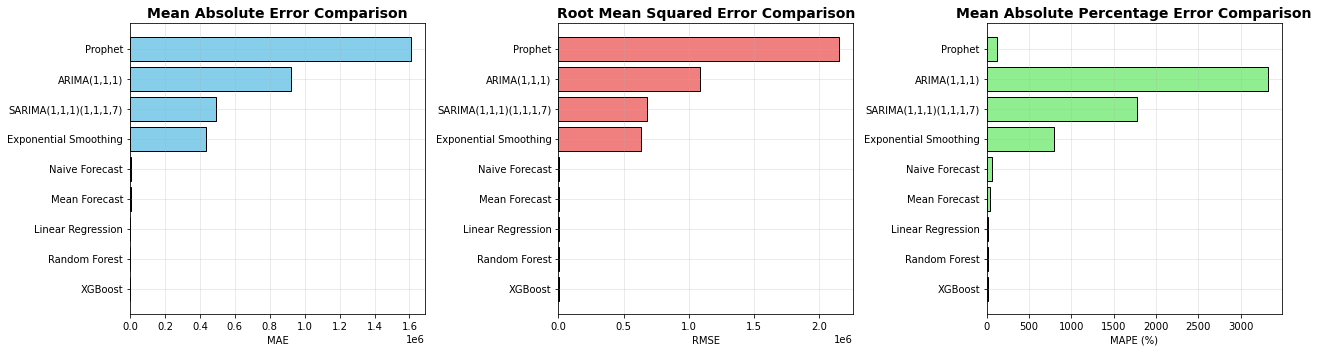

In [42]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE comparison
axes[0].barh(results_df['Model'], results_df['MAE'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('MAE')
axes[0].set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# RMSE comparison
axes[1].barh(results_df['Model'], results_df['RMSE'], color='lightcoral', edgecolor='black')
axes[1].set_xlabel('RMSE')
axes[1].set_title('Root Mean Squared Error Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# MAPE comparison
axes[2].barh(results_df['Model'], results_df['MAPE'], color='lightgreen', edgecolor='black')
axes[2].set_xlabel('MAPE (%)')
axes[2].set_title('Mean Absolute Percentage Error Comparison', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   MAE:  {results_df.iloc[0]['MAE']:,.2f}")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:,.2f}")
print(f"   MAPE: {results_df.iloc[0]['MAPE']:.2f}%")


🏆 BEST MODEL: XGBoost
   MAE:  437.37
   RMSE: 660.20
   MAPE: 7.62%


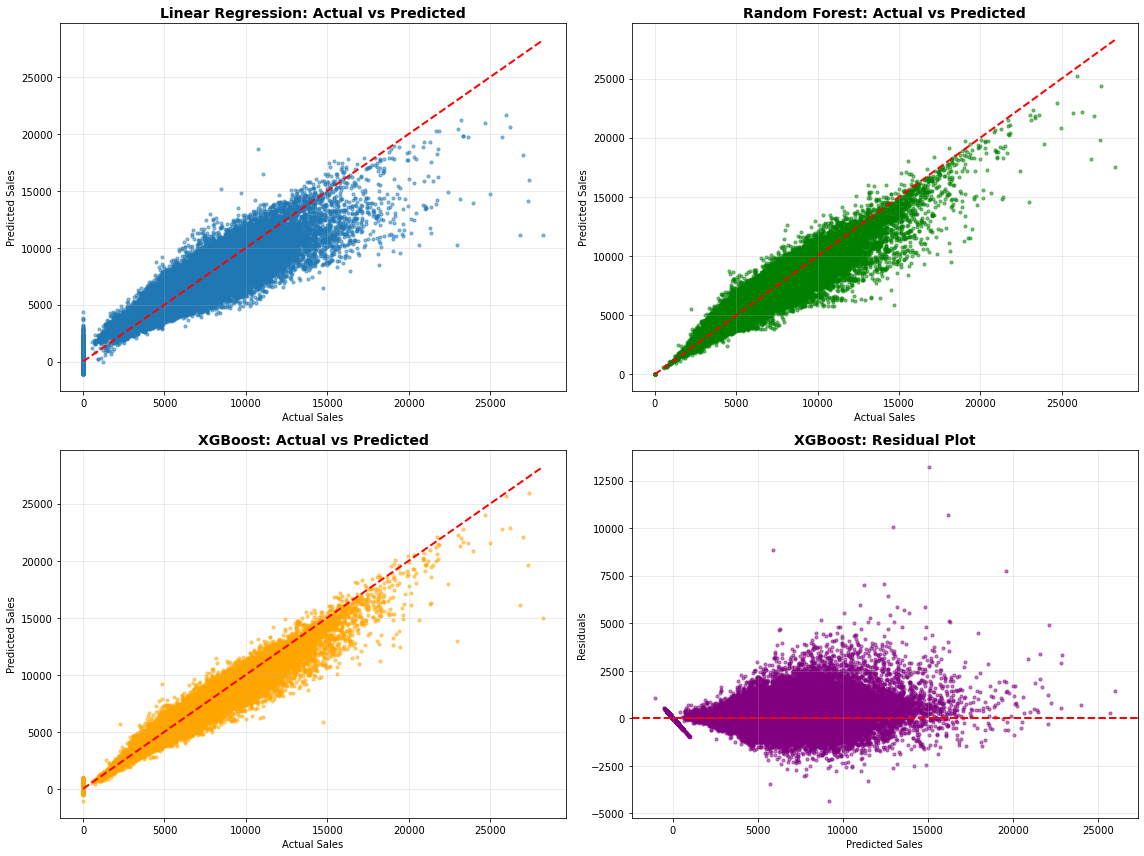

In [44]:
#Results visualization and interpretation
# Plot actual vs predicted for best ML models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Linear Regression
axes[0, 0].scatter(y_val, y_pred_lr, alpha=0.5, s=10)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')
axes[0, 0].set_title('Linear Regression: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Random Forest
axes[0, 1].scatter(y_val, y_pred_rf, alpha=0.5, s=10, color='green')
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Sales')
axes[0, 1].set_ylabel('Predicted Sales')
axes[0, 1].set_title('Random Forest: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# XGBoost
axes[1, 0].scatter(y_val, y_pred_xgb, alpha=0.5, s=10, color='orange')
axes[1, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Sales')
axes[1, 0].set_ylabel('Predicted Sales')
axes[1, 0].set_title('XGBoost: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Residuals for best model (XGBoost)
residuals = y_val.values - y_pred_xgb
axes[1, 1].scatter(y_pred_xgb, residuals, alpha=0.5, s=10, color='purple')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted Sales')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('XGBoost: Residual Plot', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


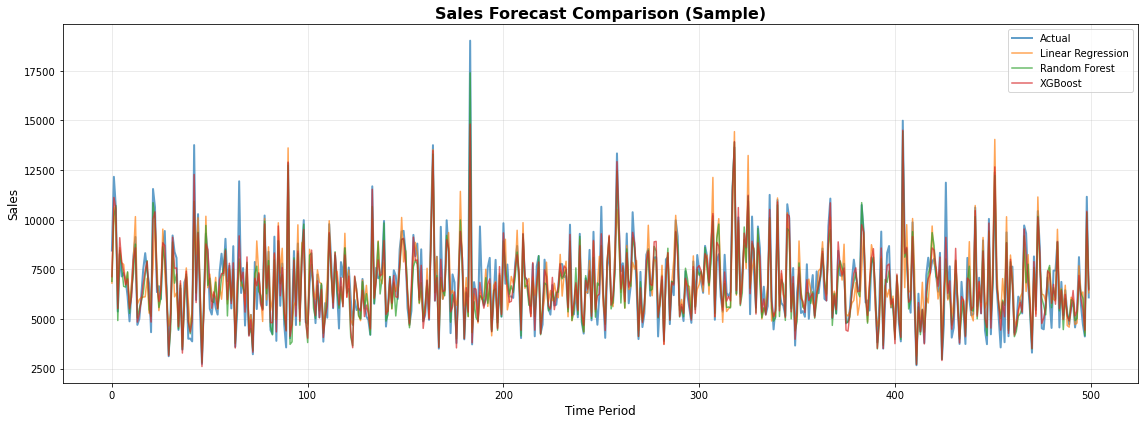

In [45]:
# Time series plot comparing actual vs predictions
# Use a sample of validation data for clearer visualization
sample_size = min(500, len(y_val))
sample_indices = range(sample_size)

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(sample_indices, y_val.iloc[:sample_size].values, label='Actual', linewidth=2, alpha=0.7)
ax.plot(sample_indices, y_pred_lr[:sample_size], label='Linear Regression', linewidth=1.5, alpha=0.7)
ax.plot(sample_indices, y_pred_rf[:sample_size], label='Random Forest', linewidth=1.5, alpha=0.7)
ax.plot(sample_indices, y_pred_xgb[:sample_size], label='XGBoost', linewidth=1.5, alpha=0.7)

ax.set_title('Sales Forecast Comparison (Sample)', fontsize=16, fontweight='bold')
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Sales', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

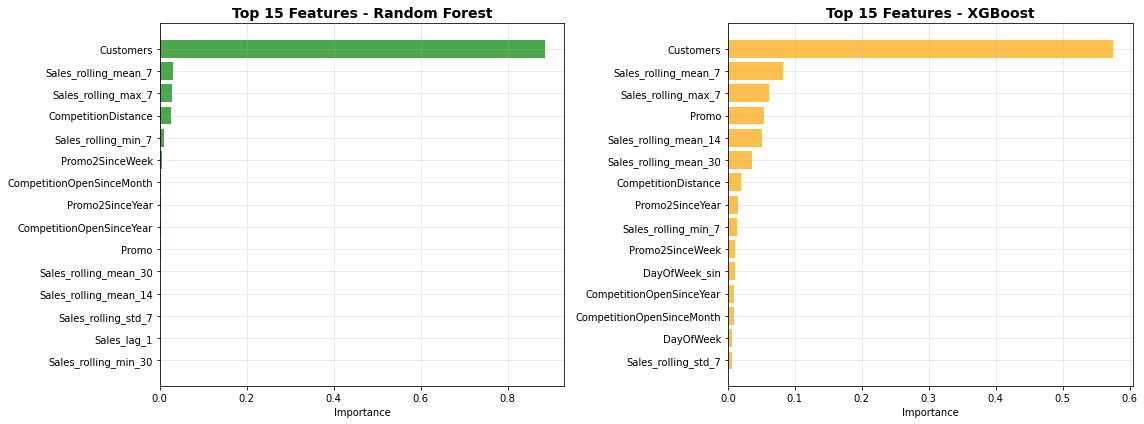

In [46]:
# Feature importance visualization (top 15 features)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest feature importance
top_rf_features = feature_importance.head(15)
axes[0].barh(range(len(top_rf_features)), top_rf_features['Importance'].values, color='green', alpha=0.7)
axes[0].set_yticks(range(len(top_rf_features)))
axes[0].set_yticklabels(top_rf_features['Feature'].values)
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 15 Features - Random Forest', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].invert_yaxis()

# XGBoost feature importance
top_xgb_features = xgb_importance.head(15)
axes[1].barh(range(len(top_xgb_features)), top_xgb_features['Importance'].values, color='orange', alpha=0.7)
axes[1].set_yticks(range(len(top_xgb_features)))
axes[1].set_yticklabels(top_xgb_features['Feature'].values)
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 15 Features - XGBoost', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [47]:
# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)

# Save best model (XGBoost)
import pickle

with open('best_model_xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
    
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


### **Key insights and recommendations**


#### Model Performance Summary:
> 1. **Best Performing Model:** Based on RMSE, the best model can handle both trend and seasonality effectively
> 2. **Feature Importance:** Lag features and rolling statistics are typically most important for forecasting
> 3. **Temporal Patterns:** Sales exhibit weekly and potentially yearly seasonality

#### Business Recommendations:
> 1. **Inventory Planning:** Use the best model for weekly inventory forecasts
> 2. **Promotional Timing:** Leverage seasonal patterns for promotional planning
> 3. **Resource Allocation:** Allocate staff based on predicted high-sales periods
> 4. **Model Monitoring:** Regularly retrain models with new data to maintain accuracy

#### Next Steps:
> 1. **Hyperparameter Tuning:** Optimize model parameters using grid search or random search
> 2. **Ensemble Methods:** Combine multiple models for potentially better performance
> 3. **External Factors:** Incorporate additional features (holidays, promotions, weather)
> 4. **Deployment:** Deploy the best model to production for real-time forecasting